# Plot full tree with library strains highlighted

In [1]:
from IPython.display import HTML
import re
import copy
import pandas as pd
import baltic as bt
import os

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Polygon

import numpy as np
import itertools
import requests


from io import StringIO as sio
from io import BytesIO as csio

from Bio import Phylo
import ete3

typeface='sans'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

In [2]:
# Input and output directories
datadir = 'data/'
resultsdir = 'results/'

os.makedirs(datadir, exist_ok=True)
os.makedirs(resultsdir, exist_ok=True)

## Plot from Nextstrain seasonal-flu TimeTree builds

In [3]:
# Add subclade labels to leaf nodes
strain_metadata = pd.read_csv('./data/nextclade.csv', sep = ';')

# Get library names
library_names = strain_metadata.seqName.unique()

# Get subclade to library name dict
libraryStrain_to_Subclade_dict = strain_metadata.set_index('seqName')['subclade'].to_dict()

In [4]:
# Identify treefile
json_treefile = './data/h3n2_ha.json'

In [5]:
json_translation = {
    'absoluteTime': lambda k: k.traits['node_attrs']['num_date']['value'], 
    'name': 'name'
} ## allows baltic to find correct attributes in JSON, height and name are required at a minimum

ll, meta = bt.loadJSON(json_treefile,json_translation=json_translation) ## give loadJSON the name of the tree file, the translation dictionary and (optionally) the meta file



Tree height: 12.298000
Tree length: 387.978000
annotations present

Numbers of objects in tree: 3203 (1470 nodes and 1733 leaves)



In [6]:
# identify library strain names file
library_strainNames_file = './data/H3N2library_2023-2024_strain_names.csv'
# initialize empty list for strain names
library_strains_ls = []

with open(library_strainNames_file, 'r',) as f:
    for line in f:
        line = line.replace('\n', '')
        line = line.replace(' ','')
        if line != 'strain':
            library_strains_ls.append(line)

# Some names don't match those from GISAID
lib_string_replace = {
    # Circulating strains that mostly need spaces removed
    'A/Abu_Dhabi/6753/2023': 'A/AbuDhabi/6753/2023',
    'A/SOUTH_AFRICA/R07876/202023': 'A/SOUTHAFRICA/R07876/202023',
    'A/Samut_Songkhram/THIS061/2023': 'A/SamutSongkhram/THIS061/2023',
    'A/South_Africa/R05510/2023': 'A/SouthAfrica/R05510/2023',
    'A/South_Africa/R07188/2023': 'A/SouthAfrica/R07188/2023',
    'A/South_Africa/R06477/2023': 'A/SouthAfrica/R06477/2023',
    'A/South_Africa/R06240/2023': 'A/SouthAfrica/R06240/2023',
    'A/Samut_Songkhram/THIS061/2023': 'A/SamutSongkhram/THIS061/2023',
    'A/South_Africa/K056872/2023': 'A/SouthAfrica/K056872/2023',
    'A/South_Africa/R06359/2023': 'A/SouthAfrica/R06359/2023',
    'A/South_Africa/R06506/2023': 'A/SouthAfrica/R06506/2023',
    'A/South_Africa/R07073/2023': 'A/SouthAfrica/R07073/2023',
    'A/Surat_Thani/P152/2023': 'A/SuratThani/P152/2023',
    'A/South_Dakota/22/2023': 'A/SouthDakota/22/2023',
    'A/South_Africa/KO56863/2023': 'A/SouthAfrica/K056863/2023',
    'A/South_Africa/R05384/2023': 'A/SouthAfrica/R05384/2023',
    
    # Vaccine strains that have more complicated things going on...
    'A/Cambodia/e0826360/2020_egg': 'A/Cambodia/e0826360/2020egg',
    'A/Hong_Kong/4801/2014_(15/192)': 'A/HongKong/4801/2014egg',
    'A/Hong_Kong/4801/2014': 'A/HongKong/4801/2014', 
    'A/Singapore/INFIMH-16-0019/2016_X-307A': 'A/Singapore/INFIMH-16-0019/2016X-307A',
    'A/Texas/50/2012_X-223A_(13/252)': 'A/Texas/50/2012X-223A',
    'A/Hong_Kong/45/2019': 'A/HongKong/45/2019',
    'A/Hong_Kong/2671/2019': 'A/HongKong/2671/2019',
    'A/Switzerland/9715293/2013_NIB-88': 'A/Switzerland/9715293/2013NIB-88',

    # Massachusetts vaccine strain
    'A/Singapore/NUH0526/2023': 'A/Massachusetts/18/2022'
    

                 }

# Do a string replace 
library_strain_names_edit = [lib_string_replace.get(item, item) for item in library_strains_ls]

# Remove egg-passaged Kansas -- this strain was excldued from the library due to poor titers

library_strain_names_edit

['A/Switzerland/9715293/2013',
 'A/Switzerland/9715293/2013NIB-88',
 'A/Texas/50/2012X-223A',
 'A/Texas/50/2012',
 'A/HongKong/4801/2014egg',
 'A/HongKong/4801/2014',
 'A/HongKong/45/2019',
 'A/HongKong/2671/2019',
 'A/Singapore/INFIMH-16-0019/2016',
 'A/Singapore/INFIMH-16-0019/2016X-307A',
 'A/Kansas/14/2017',
 'A/Cambodia/e0826360/2020',
 'A/Darwin/6/2021',
 'A/Cambodia/e0826360/2020egg',
 'A/Darwin/9/2021',
 'A/AbuDhabi/6753/2023',
 'A/Georgia/40/2023',
 'A/California/81/2023',
 'A/Wisconsin/27/2023',
 'A/Maldives/852/2023',
 'A/Oman/3011/2023',
 'A/SOUTHAFRICA/R07876/202023',
 'A/Bhutan/0845/2023',
 'A/Netherlands/01693/2023',
 'A/Bangkok/P3755/2023',
 'A/Krabi/THIS050/2023',
 'A/Netherlands/01685/2023',
 'A/Netherlands/01760/2023',
 'A/Chipata/15-NIC-001/2023',
 'A/Malaysia/IMR-SARI1989/2023',
 'A/Massachusetts/18/2022',
 'A/Victoria/1033/2023',
 'A/Catalonia/NSVH102124476/2023',
 'A/Sydney/749/2023',
 'A/Townsville/68/2023',
 'A/Sydney/710/2023',
 'A/Sydney/332/2023',
 'A/SouthA

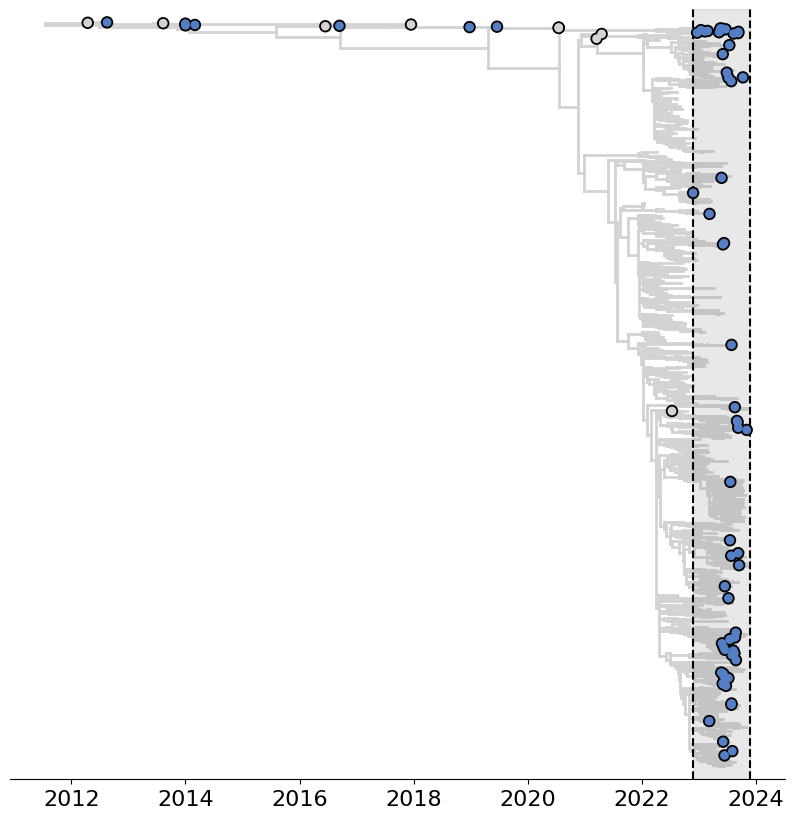

In [7]:
fig = plt.figure(figsize=(10,10),facecolor='w') ## create figure
# gs = gridspec.GridSpec(1,1,wspace=0.0) ## using gridspec by default
ax=plt.subplot(
    # gs[0],
    facecolor='w') ## create axes

vaccine_strain_ls = ['A/Texas/50/2012', 'A/Texas/50/2012_X-223A_13/252',
                     'A/Switzerland/9715293/2013', 'A/Switzerland/9715293/2013_NIB-88',
                     'A/Hong_Kong/4801/2014egg', 'A/Hong_Kong/4801/2014',
                     'A/Singapore/INFIMH-16-0019/2016', 'A/Singapore/INFIMH-16-0019/2016_X-307A',
                     'A/Kansas/14/2017', 'A/Kansas/14/2017_X-327',
                     'A/Hong_Kong/45/2019', 'A/Hong_Kong/2671/2019',
                     'A/Cambodia/e0826360/2020', 'A/Cambodia/e0826360/2020egg',
                     'A/Darwin/6/2021', 'A/Darwin/9/2021',
                     'A/Massachusets/18/2022', 
                     'A/Thailand/8/2022']

# colors and sizes for vaccine strains and library strains
point_colour = lambda k: 'lightgrey' if k.name in vaccine_strain_ls else '#557fc4' if k.name in library_strains_ls else 'black' ## colour red if vaccine strain, blue if circulating, otherwise black
point_size = lambda k: 40 if k.name in vaccine_strain_ls else 40 if k.name in library_strains_ls else 0

# x coordinate will be absolute time of node
x_attr=lambda k: k.absoluteTime

ll.plotTree(ax,
            x_attr=x_attr,
            colour= 'lightgrey',
            linewidths = 0.1,
            zorder=1) ## plot collapsed tree
ll.plotPoints(ax,
              x_attr=x_attr,
              target=lambda k: k.is_leaf(),
              size=point_size,
              colour=point_colour,
              zorder=4000) ## plot points on tips

# X-axis tick params
ax.tick_params(axis='x',labelsize=16)

ax.set_ylim(-30,ll.ySpan+30)

# Remove ticks and spines except bottom
[ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
ax.set_yticks([])
ax.set_yticklabels([])


# Add vertical line at library design
library_design_date = 2023.8877
plt.axvline(x=library_design_date, color='black', linestyle='--')

# Add vertical line 12 months prior to library design
prior_date = 2022.8877
plt.axvline(x=prior_date, color='black', linestyle='--')

# Add shaded box over library design period
# Add a shaded box between x1 and x2
plt.axvspan(prior_date, library_design_date, color='gray', alpha=0.18)


plt.draw()

# Save plot
outfile = os.path.join('./results/full_tree_library_highlighted.png')
plt.savefig(outfile, dpi = 600, bbox_inches = 'tight')

plt.show()



## Get subtree starting from most recent common ancestor of circulating strains

In [8]:
historical_vaccine_strains = [
    'A/Texas/50/2012', 'A/Texas/50/2012X-223A',
    'A/Switzerland/9715293/2013', 'A/Switzerland/9715293/2013NIB-88',
    'A/HongKong/4801/2014', 'A/HongKong/4801/2014egg',
    'A/Singapore/INFIMH-16-0019/2016', 'A/Singapore/INFIMH-16-0019/2016X-307A',
    'A/Kansas/14/2017', 'A/Kansas/14/2017X-327',
    'A/HongKong/45/2019', 'A/HongKong/2671/2019',
    'A/Cambodia/e0826360/2020', 'A/Cambodia/e0826360/2020egg',
    'A/Darwin/6/2021', 'A/Darwin/9/2021',
]

keep_tips=[k for k in ll.Objects if k.is_leaf() and k.name not in historical_vaccine_strains] ## list of leaf objects that will remain in the tree - here only circulating strains in library
# keep_tips=[k for k in ll.Objects if k.is_leaf() and k.name in library_strain_names_edit] ## list of leaf objects that will remain in the tree - here only circulating strains in library
recent_tree=ll.reduceTree(keep_tips) ## retrieve a reduced tree (multitype by default)
recent_tree.treeStats()


Tree height: 12.298000
Tree length: 373.612000
multitype tree
annotations present

Numbers of objects in tree: 3180 (1463 nodes and 1717 leaves)



In [9]:
## MRCA of recent tree
ancestor = recent_tree.commonAncestor(keep_tips)
ancestor

## Get subtree
recent_subtree = recent_tree.subtree(k=ancestor, 
                                     stem=True
                              # traverse_condition=lambda node: node.traits['some_state'] == some_node.traits['some_state']
                             ) 
## will only traverse through children in the same trait state as the starting node
recent_subtree.treeStats()


Tree height: 4.548000
Tree length: 366.197000
annotations present

Numbers of objects in tree: 3175 (1456 nodes and 1719 leaves)



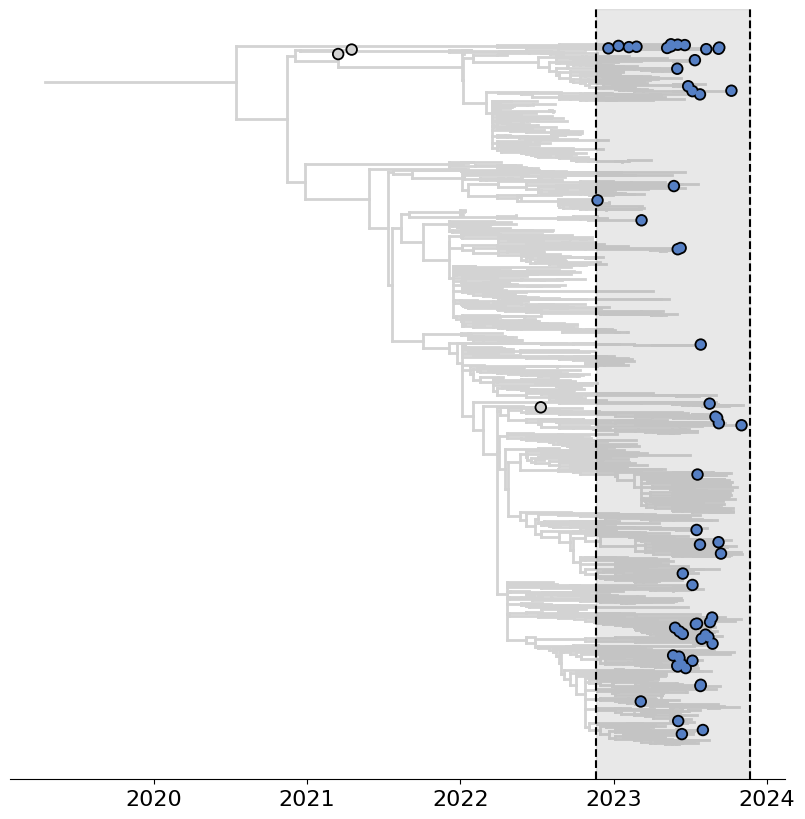

In [10]:
fig = plt.figure(figsize=(10,10),facecolor='w') ## create figure
ax=plt.subplot(
    facecolor='w') ## create axes

subtree_vaccine_strains = [
    'A/Darwin/6/2021', 
    'A/Darwin/9/2021',
    'A/Massachusetts/18/2022', 
    'A/Thailand/8/2022'
]

egg_subtree_vaccine_strains = [
    'A/Darwin/9/2021',
    'A/Thailand/8/2022'
]

# colors and sizes for vaccine strains and library strains
point_colour = lambda k: '#557fc4' if k.name not in subtree_vaccine_strains else 'lightgrey' if k.name in subtree_vaccine_strains else '#eac435' ## colour red if vaccine strain, blue if circulating, otherwise black
point_size = lambda k: 40 if k.name in vaccine_strain_ls else 40 if k.name in library_strains_ls else 0

# x coordinate will be absolute time of node
x_attr=lambda k: k.absoluteTime

recent_subtree.plotTree(ax,
            x_attr=x_attr,
            colour= 'lightgrey',
            linewidths = 0.1,
            zorder=1) ## plot tree
recent_subtree.plotPoints(ax,
              x_attr=x_attr,
              target=lambda k: k.is_leaf(),
              size=point_size,
              colour=point_colour,
              zorder=4000) ## plot points on tips

# X-axis tick params
ax.tick_params(axis='x',labelsize=16)

# Remove ticks and spines except bottom
[ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
ax.set_yticks([])
ax.set_yticklabels([])

# Custom x-axis
ax.set_xticks([2020,2021,2022,2023,2024])


# Add vertical line at library design
library_design_date = 2023.8877
plt.axvline(x=library_design_date, color='black', linestyle='--')

# Add vertical line 12 months prior to library design
prior_date = 2022.8877
plt.axvline(x=prior_date, color='black', linestyle='--')

# Add shaded box over library design period
# Add a shaded box between x1 and x2
plt.axvspan(prior_date, library_design_date, color='gray', alpha=0.18)


plt.draw()

# Save plot
outfile = os.path.join('./results/recent_tree_library_highlighted.png')
plt.savefig(outfile, dpi = 600, bbox_inches = 'tight')

plt.show()



## Reduce tree to just vaccine strains

In [11]:
vaccine_strains = [
    'A/Texas/50/2012', 'A/Texas/50/2012X-223A',
    'A/Switzerland/9715293/2013', 'A/Switzerland/9715293/2013NIB-88',
    'A/HongKong/4801/2014', 'A/HongKong/4801/2014egg',
    'A/Singapore/INFIMH-16-0019/2016', 'A/Singapore/INFIMH-16-0019/2016X-307A',
    'A/Kansas/14/2017', 
    # 'A/Kansas/14/2017X-327',
    'A/HongKong/45/2019', 'A/HongKong/2671/2019',
    'A/Cambodia/e0826360/2020', 'A/Cambodia/e0826360/2020egg',
    'A/Darwin/6/2021', 'A/Darwin/9/2021',
    'A/Massachusetts/18/2022', 
    'A/Thailand/8/2022'
    
]

keep_tips=[k for k in ll.Objects if k.is_leaf() and k.name in vaccine_strains] ## list of leaf objects that will remain in the tree - here only circulating strains in library
# keep_tips=[k for k in ll.Objects if k.is_leaf() and k.name in library_strain_names_edit] ## list of leaf objects that will remain in the tree - here only circulating strains in library
vaccine_tree=ll.reduceTree(keep_tips) ## retrieve a reduced tree (multitype by default)
vaccine_tree.treeStats()


Tree height: 10.981000
Tree length: 25.490000
multitype tree
annotations present

Numbers of objects in tree: 49 (32 nodes and 17 leaves)



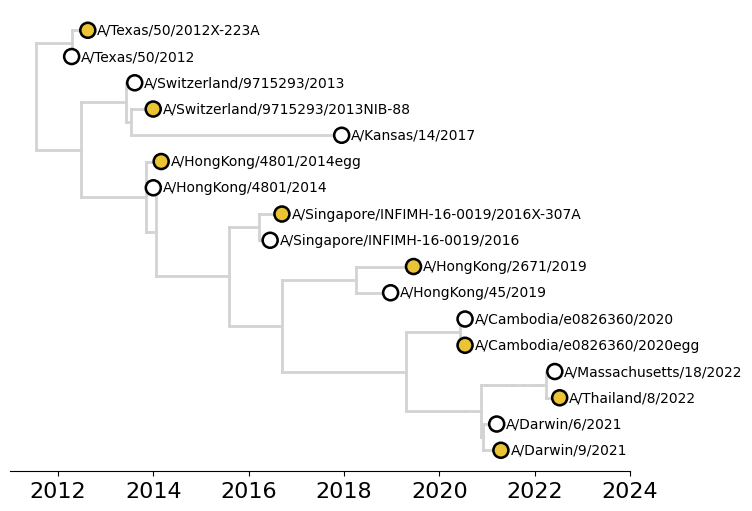

In [12]:
fig = plt.figure(figsize=(8,6),facecolor='w') ## create figure
ax=plt.subplot(
    facecolor='w') ## create axes

egg_vaccines = [
    'A/Texas/50/2012X-223A',
    'A/Switzerland/9715293/2013NIB-88',
    'A/HongKong/4801/2014egg',
    'A/Singapore/INFIMH-16-0019/2016X-307A',
    # 'A/Kansas/14/2017X-327',
    'A/HongKong/2671/2019',
    'A/Cambodia/e0826360/2020egg',
    'A/Darwin/9/2021',
    'A/Thailand/8/2022'
]

# colors and sizes for vaccine strains and library strains
point_colour = lambda k: '#eac435' if k.name in egg_vaccines else 'white' if k.name in vaccine_strains else 'black' ## colour red if vaccine strain, blue if circulating, otherwise black
# point_shape = 
point_size = lambda k: 80 if k.name in egg_vaccines else 80 if k.name in vaccine_strains else 0

# x coordinate will be absolute time of node
x_attr=lambda k: k.absoluteTime

vaccine_tree.plotTree(ax,
            x_attr=x_attr,
            colour= 'lightgrey',
            linewidths = 0.1,
            zorder=1) ## plot tree
vaccine_tree.plotPoints(ax,
              x_attr=x_attr,
              target=lambda k: k.is_leaf(),
              size=point_size,
              colour=point_colour,
              zorder=4000) ## plot points on tips

# X-axis tick params
ax.tick_params(axis='x',labelsize=16)
# Custom x-axis
ax.set_xticks([2012,2014,2016,2018,2020,2022,2024])


# Remove ticks and spines except bottom
[ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
ax.set_yticks([])
ax.set_yticklabels([])

# Add node text
target_func=lambda k: k.is_leaf() ## which branches will be annotated
text_func=lambda k: (k.name) ## what text is plotted
text_x_attr=lambda k: k.absoluteTime+0.2 ## where x coordinate for text is
kwargs={'va':'center','ha':'left','size': 10} ## kwargs for text

vaccine_tree.addText(ax,x_attr=text_x_attr,target=target_func,text=text_func,**kwargs) ## text will use a different x attribute function to shift it to the right



plt.draw()

# Save plot
outfile = os.path.join('./results/vaccine_tree.png')
plt.savefig(outfile, dpi = 600, bbox_inches = 'tight')

plt.show()



## Reduce tree to just those in the library

In [14]:
keep_tips=[k for k in ll.Objects if k.is_leaf() and k.name in library_strain_names_edit] ## list of leaf objects that will remain in the tree - here only circulating strains in library
# keep_tips=[k for k in ll.Objects if k.is_leaf() and k.name in library_strain_names_edit] ## list of leaf objects that will remain in the tree - here only circulating strains in library
library_tree=ll.reduceTree(keep_tips) ## retrieve a reduced tree (multitype by default)
library_tree.treeStats()


Tree height: 12.290000
Tree length: 74.951000
multitype tree
annotations present

Numbers of objects in tree: 423 (345 nodes and 78 leaves)



In [15]:
tree_strains = []
for l in library_tree.Objects:
    if l.is_leaf():
        tree_strains.append(l.name)

for strain in library_strain_names_edit:
    if strain not in tree_strains:
        print(strain)

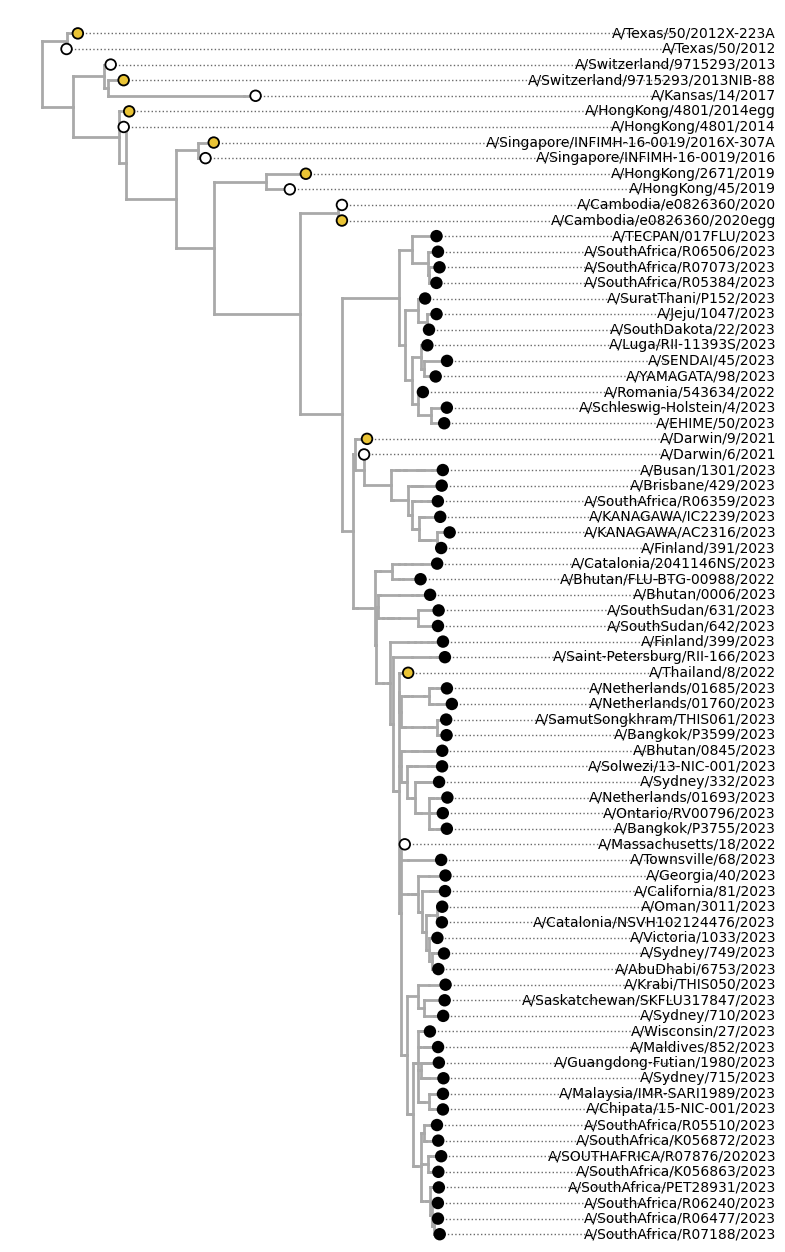

In [16]:
fig = plt.figure(figsize=(9,16),facecolor='w') ## create figure
# gs = gridspec.GridSpec(1,1,wspace=0.0) ## using gridspec by default
ax=plt.subplot(
    # gs[0],
    facecolor='w') ## create axes


# colors and sizes for vaccine strains and library strains
# point_colour = lambda k: 'lightgrey' if k.name in vaccine_strain_ls else strain_edit_to_color_dict[k.name] # Color branch if vaccine strain, otherwise subclade specific

point_size = lambda k: 40 if k.name in library_strain_names_edit else 0

# x coordinate will be absolute time of node
x_attr=lambda k: k.absoluteTime

# Plot tree and points
library_tree.plotTree(ax,
            colour='darkgrey',
            linewidths = 0.2,
            zorder=10) ## plot collapsed tree
library_tree.plotPoints(ax,target=lambda k: k.is_leaf(),
              size=point_size,
              colour=point_colour,
              zorder=14) ## plot points on tips

# Start finagling the node labels
target_func=lambda k: k.is_leaf() ## which branches will be annotated
text_func=lambda k: k.name ## what text is plotted
text_x_attr=lambda k: 22 ## where x coordinate for text is

kwargs={'va':'center','ha':'right','size': 10,
        # 'backgroundcolor': 'white',
        # 'antialiased': True,
        # 'snap': True,
       } ## kwargs for text

library_tree.addText(ax,
                     x_attr=text_x_attr,
                     target=target_func,
                     text=text_func,
                     **kwargs) ## text will use a different x attribute function to shift it to the right


# Draw lines from leaves to text
for k in library_tree.getExternal(): ## iterate over tips
    # get width of each text object so we have coordinates of end of line
    f = plt.figure()
    r = f.canvas.get_renderer()
    t = plt.text(0.8, 0.8, k.name, **kwargs)
    bb = t.get_window_extent(renderer=r)
    width = bb.width/90
    plt.close()

    # draw line
    ax.plot([k.height, 19], [k.y,k.y], ls=':',lw=1,color='dimgrey') ## grey lines from every tip's date to the most recent date



# X-axis tick params
ax.set_xticks([])

# Y-axis span
ax.set_ylim(0,library_tree.ySpan+1)

# Remove ticks and spines except bottom
[ax.spines[loc].set_visible(False) for loc in ax.spines]
ax.set_yticks([])
ax.set_yticklabels([])


plt.draw()

# Save plot
outfile = os.path.join('./results/full_library_textRight.png')
plt.savefig(outfile, dpi = 600, bbox_inches = 'tight')

plt.show()

In [17]:
# Get list of tree elements for matching titer plots
ls = []

# Get names and y coordinates of tips
for k in library_tree.getExternal(): ## iterate over tips
    ls.append([k.name, k.y, k.traits['node_attrs']['accession']])

# Sort tips by y coordinate
sorted_ls = sorted(ls, key = lambda x: int(x[1]), reverse=True)

# Get a cleaned list of just the strain name (direct from the GISAID pull!) and the accession number
virus_order_list = []

for item in sorted_ls:
    strain = item[0]
    accession = item[2]

    if strain == 'A/HongKong/4801/2014':
        accession = 'EPI_ISL_165554'
        
    virus_order_list.append([strain, accession])

# Get dataframe
ordered_strains = pd.DataFrame(virus_order_list, columns = ['strain', 'accession'])
# Save to CSV
ordered_strains.to_csv('results/ordered_strains.csv', index=False)

virus_order_list

[['A/Texas/50/2012X-223A', 'EPI_ISL_138982'],
 ['A/Texas/50/2012', 'EPI_ISL_122006'],
 ['A/Switzerland/9715293/2013', 'EPI_ISL_166310'],
 ['A/Switzerland/9715293/2013NIB-88', 'EPI_ISL_198223'],
 ['A/Kansas/14/2017', 'EPI_ISL_292575'],
 ['A/HongKong/4801/2014egg', 'EPI_ISL_176512'],
 ['A/HongKong/4801/2014', 'EPI_ISL_165554'],
 ['A/Singapore/INFIMH-16-0019/2016X-307A', 'EPI_ISL_293527'],
 ['A/Singapore/INFIMH-16-0019/2016', 'EPI_ISL_225834'],
 ['A/HongKong/2671/2019', 'EPI_ISL_400888'],
 ['A/HongKong/45/2019', 'EPI_ISL_347938'],
 ['A/Cambodia/e0826360/2020', 'EPI_ISL_944639'],
 ['A/Cambodia/e0826360/2020egg', 'EPI_ISL_806547'],
 ['A/TECPAN/017FLU/2023', 'EPI_ISL_18500240'],
 ['A/SouthAfrica/R06506/2023', 'EPI_ISL_18106136'],
 ['A/SouthAfrica/R07073/2023', 'EPI_ISL_18215900'],
 ['A/SouthAfrica/R05384/2023', 'EPI_ISL_18041737'],
 ['A/SuratThani/P152/2023', 'EPI_ISL_16645225'],
 ['A/Jeju/1047/2023', 'EPI_ISL_18231773'],
 ['A/SouthDakota/22/2023', 'EPI_ISL_17391847'],
 ['A/Luga/RII-11393S/2